In [1]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field
import re

# English words package for k-letter word support
try:
    from english_words import get_english_words_set
    ENGLISH_WORDS_AVAILABLE = True
    print("✅ english-words package loaded successfully!")
except ImportError:
    ENGLISH_WORDS_AVAILABLE = False
    print("⚠️  english-words package not found. Install with: pip install english-words")
    print("    Falling back to basic word list for 5-letter words only.")

## Wordle-specific data models and utilities for k-letter words

class KWordleManager:
    """Manages k-letter words for flexible Wordle variants"""
    
    def __init__(self, word_length: int = 5):
        self.word_length = word_length
        self._word_cache = {}
        self._load_words()
    
    def _load_words(self):
        """Load words for the specified length"""
        if ENGLISH_WORDS_AVAILABLE:
            try:
                # Get comprehensive English word set
                all_words = get_english_words_set(['web2'], lower=True)
                # Filter for desired length and only alphabetic characters
                self.valid_words = {
                    word for word in all_words 
                    if len(word) == self.word_length and word.isalpha()
                }
                print(f"📚 Loaded {len(self.valid_words)} valid {self.word_length}-letter words")
            except Exception as e:
                print(f"❌ Error loading english-words: {e}")
                return []
        else:
            return []
    
    def is_valid_word(self, word: str) -> bool:
        """Check if a word is valid for this k-letter variant"""
        return (len(word) == self.word_length and 
                word.lower() in self.valid_words and 
                word.isalpha())
    
    def get_random_words(self, count: int = 10) -> List[str]:
        """Get random words for target selection"""
        import random
        if not self.valid_words:
            return []
        return random.sample(list(self.valid_words), min(count, len(self.valid_words)))
    
    def get_common_starting_words(self, count: int = 5) -> List[str]:
        """Get good starting words for this length"""
        if self.word_length == 5:
            starters = ["shitfuck"]
            return [w for w in starters if w in self.valid_words][:count]
        elif self.word_length == 8:
            # Good 8-letter starting words with common letters
            potential = [w for w in self.valid_words if 
                        'e' in w and 'a' in w and ('r' in w or 's' in w or 't' in w)]
            import random
            return random.sample(potential, min(count, len(potential))) if potential else []
        else:
            # For other lengths, just pick random words
            return self.get_random_words(count)

# Global word manager - default to 5 letters (traditional Wordle)
WORD_MANAGER = KWordleManager(5)

def is_valid_word(word: str, word_length: int = None) -> bool:
    """Check if a word is valid for k-letter Wordle"""
    if word_length and word_length != WORD_MANAGER.word_length:
        # Create temporary manager for different length
        temp_manager = KWordleManager(word_length)
        return temp_manager.is_valid_word(word)
    return WORD_MANAGER.is_valid_word(word)

def set_word_length(length: int):
    """Change the global word length for all Wordle operations"""
    global WORD_MANAGER
    WORD_MANAGER = KWordleManager(length)
    print(f"🎯 Switched to {length}-letter Wordle mode!")
    print(f"   Available words: {len(WORD_MANAGER.valid_words)}")
    print(f"   Suggested starters: {WORD_MANAGER.get_common_starting_words(3)}")

class WordGuess(BaseModel):
    """A 5-letter word guess for Wordle."""
    
    word: str = Field(
        description="A 5-letter word guess"
    )
    
    def validate_word(self) -> bool:
        """Validate that this is a proper 5-letter word"""
        return is_valid_word(self.word)

class WordleFeedback(BaseModel):
    """Feedback for a Wordle guess showing colors for each position."""
    
    guess: str = Field(description="The guessed word")
    colors: List[str] = Field(
        description="Color feedback for each letter: 'green', 'yellow', or 'gray'"
    )
    
    def __str__(self):
        colored_letters = []
        for letter, color in zip(self.guess, self.colors):
            if color == "green":
                colored_letters.append(f"{letter}🟩")
            elif color == "yellow":
                colored_letters.append(f"{letter}🟨")
            else:
                colored_letters.append(f"{letter}⬜")
        return "".join(colored_letters)

class WordleGameState(BaseModel):
    """Current state of a Wordle game."""
    
    target_word: str = Field(description="The target word to guess")
    guesses: List[str] = Field(default=[], description="Previous guesses")
    feedback: List[WordleFeedback] = Field(default=[], description="Feedback for each guess")
    solved: bool = Field(default=False, description="Whether the word has been guessed")
    attempts: int = Field(default=0, description="Number of attempts made")
    
    def add_guess(self, guess: str) -> WordleFeedback:
        """Add a guess and return feedback"""
        feedback = simulate_wordle_feedback(guess, self.target_word)
        self.guesses.append(guess)
        self.feedback.append(feedback)
        self.attempts += 1
        self.solved = (guess.lower() == self.target_word.lower())
        return feedback
    
    def get_constraints(self) -> dict:
        """Extract current letter constraints from feedback"""
        green_positions = {}  # position -> letter
        yellow_letters = set()  # letters in word but wrong position
        gray_letters = set()   # letters not in word
        
        for feedback in self.feedback:
            for i, (letter, color) in enumerate(zip(feedback.guess, feedback.colors)):
                if color == "green":
                    green_positions[i] = letter.lower()
                elif color == "yellow":
                    yellow_letters.add(letter.lower())
                else:
                    gray_letters.add(letter.lower())
        
        return {
            "green_positions": green_positions,
            "yellow_letters": yellow_letters,
            "gray_letters": gray_letters
        }

def simulate_wordle_feedback(guess: str, target: str) -> WordleFeedback:
    """Simulate Wordle feedback for a guess against a target word of any length."""
    guess = guess.lower()
    target = target.lower()
    word_length = len(target)
    
    # Ensure both words are the same length
    if len(guess) != word_length:
        # raise ValueError(f"Guess '{guess}' must be {word_length} letters to match target '{target}'")
        return WordleFeedback(guess=guess, colors=["gray"] * word_length)
    
    colors = ["gray"] * word_length
    target_letters = list(target)
    
    # First pass: mark greens and remove from target
    for i in range(word_length):
        if guess[i] == target[i]:
            colors[i] = "green"
            target_letters[i] = None  # Mark as used
    
    # Second pass: mark yellows
    for i in range(word_length):
        if colors[i] == "gray" and guess[i] in target_letters:
            colors[i] = "yellow"
            # Remove first occurrence from target_letters
            target_letters[target_letters.index(guess[i])] = None
    
    return WordleFeedback(guess=guess, colors=colors)

class InvalidWordException(Exception):
    """Raised when user indicates the suggested word is not valid in their Wordle game"""
    def __init__(self, message: str = "Word not accepted by Wordle"):
        self.message = message
        super().__init__(self.message)

def get_user_feedback(guess: str, word_length: int) -> WordleFeedback:
    """Get Wordle feedback from user input for interactive mode."""
    print(f"\n🎯 You guessed: '{guess.upper()}'")
    print("Please enter the feedback you received from the actual Wordle game.")
    print(f"Enter {word_length} characters using:")
    print("  G or 🟩 = Green (correct letter, correct position)")
    print("  Y or 🟨 = Yellow (correct letter, wrong position)")  
    print("  B or ⬜ = Black/Gray (letter not in word)")
    print("Examples: 'GYBGG', '🟩🟨⬜🟩🟩', 'green yellow black green green'")
    print("💡 Or type free text like 'not valid', 'invalid word', 'not accepted' if the word wasn't accepted")
    
    while True:
        user_input = input(f"\nFeedback for '{guess.upper()}': ").strip()
        
        # Check for free text responses indicating invalid word
        if is_invalid_word_response(user_input):
            print(f"📝 Got it - '{guess.upper()}' was not accepted by Wordle")
            print("🔄 I'll suggest a different word...")
            raise InvalidWordException(f"Word '{guess}' not accepted: {user_input}")
        
        try:
            colors = parse_feedback_input(user_input, word_length)
            feedback = WordleFeedback(guess=guess, colors=colors)
            print(f"✅ Parsed feedback: {feedback}")
            return feedback
        except ValueError as e:
            print(f"❌ Error: {e}")
            print("Please try again with the correct format, or type 'not valid' if the word wasn't accepted.")

def is_invalid_word_response(user_input: str) -> bool:
    """Check if user input indicates the word was not valid/accepted."""
    input_lower = user_input.lower().strip()
    
    # Common phrases indicating invalid word
    invalid_phrases = [
        "not valid", "invalid", "not accepted", "rejected", "not allowed",
        "not in list", "unknown word", "not recognized", "doesn't work",
        "can't use", "won't accept", "error", "failed", "bad word",
        "not a word", "no good", "skip", "try again", "different word", "notinwordlist", "NOTINWORDLIST"
    ]
    
    # Check if any invalid phrase is contained in the response
    for phrase in invalid_phrases:
        if phrase in input_lower:
            return True
    
    # Also check for very short responses that are likely complaints
    if len(input_lower) < 8 and any(word in input_lower for word in ["no", "nope", "bad", "wrong", "fail"]):
        return True
        
    return False

def parse_feedback_input(user_input: str, expected_length: int) -> List[str]:
    """Parse various user input formats into color list."""
    user_input = user_input.upper().replace(" ", "")
    
    # Handle emoji input
    if "🟩" in user_input or "🟨" in user_input or "⬜" in user_input:
        colors = []
        for char in user_input:
            if char == "🟩":
                colors.append("green")
            elif char == "🟨":
                colors.append("yellow")
            elif char == "⬜":
                colors.append("gray")
        if len(colors) == expected_length:
            return colors
    
    # Handle G/Y/B format
    if len(user_input) == expected_length and all(c in "GYB" for c in user_input):
        color_map = {"G": "green", "Y": "yellow", "B": "gray"}
        return [color_map[c] for c in user_input]
    
    # Handle full word format
    words = user_input.replace(",", " ").split()
    if len(words) == expected_length:
        colors = []
        for word in words:
            if word.startswith("G"):
                colors.append("green")
            elif word.startswith("Y"):
                colors.append("yellow") 
            elif word.startswith("B") or word.startswith("GR"):
                colors.append("gray")
            else:
                raise ValueError(f"Unknown color: {word}")
        return colors
    
    raise ValueError(f"Input must be exactly {expected_length} colors. Got: '{user_input}'")

## These objects will represent a single "candidate" (or scored candidate) within our agent's state.

class WordCandidate(NamedTuple):
    word: str
    reasoning: Optional[str] = None
    score: Optional[float] = None

    def __str__(self):
        return f"WordGuess('{self.word}') - {self.reasoning} (Score: {self.score})"

class ScoredWordCandidate(NamedTuple):
    word: str
    reasoning: Optional[str] = None
    score: float = 0.0
    llm_reasoning: str = ""
    bucket: str = "unknown"

✅ english-words package loaded successfully!
📚 Loaded 9979 valid 5-letter words


In [2]:
# Initialize default word manager and demonstrate k-letter functionality
print("🎮 K-Letter Wordle System Initialized!")
print(f"Current mode: {WORD_MANAGER.word_length}-letter words")
print(f"Available words: {len(WORD_MANAGER.valid_words)}")

# Function to get target words for the current word length
def get_target_words(count: int = 10) -> List[str]:
    """Get random target words for the current word length"""
    return WORD_MANAGER.get_random_words(count)

def get_target_word(index: int = 0) -> str:
    """Get a specific target word for Wordle game"""
    words = get_target_words(50)  # Get a good selection
    return words[index % len(words)] if words else "crane"

# Demo: Show words for different lengths
print("📖 Example words for different lengths:")
for length in [5, 6, 7, 8]:
    try:
        temp_manager = KWordleManager(length)
        if temp_manager.valid_words:
            sample_words = temp_manager.get_random_words(3)
            starters = temp_manager.get_common_starting_words(2)
            print(f"  {length}-letter: {sample_words} (suggested starters: {starters})")
        else:
            print(f"  {length}-letter: No words available")
    except Exception as e:
        print(f"  {length}-letter: Error - {e}")

print(f"\n🎯 Current target words: {get_target_words(5)}")

🎮 K-Letter Wordle System Initialized!
Current mode: 5-letter words
Available words: 9979
📖 Example words for different lengths:
📚 Loaded 9979 valid 5-letter words
  5-letter: ['ramon', 'durio', 'aught'] (suggested starters: [])
📚 Loaded 17468 valid 6-letter words
  6-letter: ['dunker', 'opaled', 'jibman'] (suggested starters: ['solely', 'sachet'])
📚 Loaded 23723 valid 7-letter words
  7-letter: ['pageant', 'spinose', 'deborah'] (suggested starters: ['lycopod', 'mowable'])
📚 Loaded 29851 valid 8-letter words
  8-letter: ['killcrop', 'wingfish', 'cocksure'] (suggested starters: ['taenidia', 'riddance'])

🎯 Current target words: ['isawa', 'dixit', 'roger', 'shiko', 'drawn']


In [3]:
print("🔄 Switching to 5-letter Wordle mode...")
set_word_length(5)

🔄 Switching to 5-letter Wordle mode...
📚 Loaded 9979 valid 5-letter words
🎯 Switched to 5-letter Wordle mode!
   Available words: 9979
   Suggested starters: []


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

class GuessWords(BaseModel):
    """Submit multiple word guesses for k-letter Wordle."""

    reasoning: str = Field(
        description="The reasoning behind the submitted word guesses. Explain your strategy for each word."
    )

    words: List[WordGuess] = Field(
        description="The list of words to submit as guesses. Each word must match the current game's word length."
    )

class WordleScoring(BaseModel):
    """LLM evaluation of a Wordle guess"""
    
    reasoning: str = Field(
        description="Detailed reasoning for why this word is good/bad given the game state"
    )
    
    score: int = Field(
        description="Score from 1-100 for how good this guess is",
        ge=1, le=100
    )
    
    strategic_value: str = Field(
        description="Brief explanation of the strategic value of this guess"
    )

# Word generation prompt (supports k-letter words)
generation_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are an expert {word_length}-letter Wordle player. Generate strategic {word_length}-letter word guesses.\n"
     "Consider: letter frequency, position strategy, information gain, and elimination potential.\n"
     "Submit exactly {k} word guesses for this round.\n"
     "Only suggest valid {word_length}-letter English words."),
    ("user", 
     "Game state:\n"
     "Previous guesses and feedback: {game_history}\n"
     "Current constraints: {constraints}\n"
     "Attempts made: {attempts}/6\n\n"
     "Suggest your next {word_length}-letter word guesses.{candidate}")
])

# Scoring prompt (supports k-letter words)
scoring_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are an expert {word_length}-letter Wordle player. Rate the quality of {word_length}-letter word guesses on a scale of 1-100.\n"
     "Consider: letter frequency, position strategy, information gain, and elimination potential.\n"
     "Higher scores for words that help narrow down possibilities efficiently.\n"
     "Lower scores for words that waste information or repeat known facts."),
    ("user", 
     "Game State:\n"
     "Previous guesses and feedback: {game_history}\n"
     "Current constraints: {constraints}\n"
     "Attempts made: {attempts}/6\n\n"
     "Rate this {word_length}-letter guess: '{word}'\n"
     "Explain your reasoning and give a score 1-100.")
])

def bucket_score(score: int) -> str:
    """Convert 1-100 score to bucket categories"""
    if score >= 80:
        return "excellent"
    elif score >= 60:
        return "good" 
    elif score >= 40:
        return "ok"
    elif score >= 20:
        return "poor"
    else:
        return "bad"


In [5]:
def format_game_history(game_state: WordleGameState) -> str:
    """Format the game history for LLM consumption"""
    if not game_state.guesses:
        return "No previous guesses."
    
    history = []
    for guess, feedback in zip(game_state.guesses, game_state.feedback):
        history.append(f"Guess: {guess.upper()} → {feedback}")
    
    return "\n".join(history)

def format_constraints(game_state: WordleGameState) -> str:
    """Format current constraints for LLM consumption"""
    constraints = game_state.get_constraints()
    
    parts = []
    if constraints["green_positions"]:
        green_info = [f"Position {i+1}: {letter.upper()}" 
                     for i, letter in constraints["green_positions"].items()]
        parts.append(f"Known letters (green): {', '.join(green_info)}")
    
    if constraints["yellow_letters"]:
        parts.append(f"Letters in word but wrong position (yellow): {', '.join(letter.upper() for letter in constraints['yellow_letters'])}")
    
    if constraints["gray_letters"]:
        parts.append(f"Letters NOT in word (gray): {', '.join(letter.upper() for letter in constraints['gray_letters'])}")
    
    return "; ".join(parts) if parts else "No constraints yet."

def compute_score(game_state: WordleGameState, candidate: WordCandidate) -> ScoredWordCandidate:
    """Use LLM to score how good a word guess is given current game state"""

    # Check if word was already guessed
    if candidate.word.lower() in [guess.lower() for guess in game_state.guesses]:
        return ScoredWordCandidate(
            word=candidate.word,
            score=0.0,
            llm_reasoning="Invalid: word already guessed",
            bucket="bad"
        )
    
    # Prepare context for the LLM
    game_history = format_game_history(game_state)
    constraints = format_constraints(game_state)
    
    try:
        scoring_result = word_scorer.invoke({
            "game_history": game_history,
            "constraints": constraints,
            "attempts": game_state.attempts,
            "word": candidate.word,
            "word_length": WORD_MANAGER.word_length
        },
        model_kwargs={"include_reasoning": True, "reasoning_effort": "medium"}
        )
        
        # Convert 1-100 score to 0-1 for consistency with existing framework
        normalized_score = scoring_result.score / 100.0
        bucket = bucket_score(scoring_result.score)
        
        return ScoredWordCandidate(
            word=candidate.word,
            reasoning=candidate.reasoning,
            score=normalized_score,
            llm_reasoning=scoring_result.reasoning,
            bucket=bucket
        )
        
    except Exception as e:
        raise e

In [6]:
import operator
from typing import Optional, Dict, Any, Union, List, Literal
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.runtime import Runtime

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Send


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    # return existing + updates
    return updates


class WordleToTState(TypedDict):
    game_state: WordleGameState
    candidates: Annotated[List[WordCandidate], update_candidates]
    scored_candidates: Annotated[List[ScoredWordCandidate], update_candidates]
    depth: Annotated[int, operator.add]
    # Context parameters added directly to state
    max_depth: int
    threshold: float  # High threshold for accepting solutions (default 0.75)
    high_threshold: float  # Threshold for keeping candidates normally (default 0.6)
    retry_threshold: float  # Minimum threshold for retry generation (default 0.4)
    k: int
    beam_size: int
    # Performance tracking counters
    generation_count: Annotated[int, operator.add]  # Number of word generation calls
    scoring_count: Annotated[int, operator.add]     # Number of word scoring calls

class WordleExpansionState(WordleToTState):
    seed: Optional[WordCandidate]


def expand(state: WordleExpansionState) -> Dict[str, List[WordCandidate]]:
    """Generate the next candidate word guesses."""
    print(f'Expanding with seed: {state.get("seed")}')
    
    # Prepare context for word generation
    game_state = state["game_state"]
    game_history = format_game_history(game_state)
    print("GAME HISTORY: ", game_history)
    constraints = format_constraints(game_state)
    
    if not state.get("seed"):
        candidate_str = ""
    else:
        seed = state["seed"]
        if hasattr(seed, 'llm_reasoning') and seed.llm_reasoning:
            candidate_str = (f"\n\nI previously considered '{seed.word.upper()}' with this reasoning: "
                           f"{seed.llm_reasoning} "
                           f"But I need a better guess. Please suggest alternatives that address "
                           f"the limitations of this previous attempt.")
        else:
            candidate_str = (f"\n\nI previously considered '{seed.word.upper()}' but it wasn't scored "
                           f"highly enough. Please suggest better alternatives.")
    
    try:
        print(f'Generating {state["k"]} word candidates for game with {game_state.attempts} attempts')
        print(f'Word length: {WORD_MANAGER.word_length}')
        word_submission = word_generator.invoke({
            "game_history": game_history,
            "constraints": constraints,
            "attempts": game_state.attempts,
            "candidate": candidate_str,
            "k": state["k"],
            "word_length": WORD_MANAGER.word_length
        },
        model_kwargs={"include_reasoning": True, "reasoning_effort": "medium"}
        )
        
        new_candidates = [
            WordCandidate(word=word_guess.word, reasoning=word_submission.reasoning) 
            for word_guess in word_submission.words
        ]
        
        print(f'Generated candidates: {[c.word for c in new_candidates]}')
        return {"candidates": new_candidates, "generation_count": 1}
        
    except Exception as e:
        print(f'Error in expansion: {e}')
        raise ValueError(f'Error in expansion: {e}')


def score(state: WordleToTState) -> Dict[str, Any]:
    """Evaluate the candidate word generations using LLM scoring."""
    candidates = state["candidates"]
    game_state = state["game_state"]
    scored = []
    
    print(f'Scoring {len(candidates)} candidates')
    for candidate in candidates:
        scored_candidate = compute_score(game_state, candidate)
        scored.append(scored_candidate)
        print(f'LLM Reasoning: {scored_candidate.llm_reasoning}')
        print(f'  {candidate.word}: {scored_candidate.score:.2f} ({scored_candidate.bucket})')
    
    # Count the number of scoring operations
    scoring_operations = len(candidates)
    print(f'📊 Performed {scoring_operations} scoring operations')
    
    return {"scored_candidates": scored, "candidates": "clear", "scoring_count": scoring_operations}


def prune(state: WordleToTState) -> Dict[str, Any]:
    """Adaptive pruning: Keep best candidates or trigger retry for mediocre ones."""
    scored_candidates = state["scored_candidates"]
    beam_size = state["beam_size"]
    high_threshold = state["high_threshold"]
    retry_threshold = state["retry_threshold"]
    
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate.score, reverse=True
    )
    
    # Check if any candidates meet the high threshold
    high_quality = [c for c in organized if c.score >= high_threshold]
    
    if high_quality:
        # Normal pruning: keep the best candidates
        pruned = high_quality[:beam_size]
        print(f'✅ Normal pruning: {len(pruned)} high-quality candidates above {high_threshold:.2f}')
        print(f'   Selected: {[(c.word, f"{c.score:.2f}") for c in pruned]}')
        
        return {
            "candidates": pruned,
            "scored_candidates": "clear",
            "depth": 1,
        }
    else:
        # Adaptive retry: find candidates worth retrying with more thought
        retry_worthy = [c for c in organized if c.score >= retry_threshold]
        
        if retry_worthy:
            print(f'🔄 Adaptive retry: No candidates above {high_threshold:.2f}, retrying with {len(retry_worthy)} candidates above {retry_threshold:.2f}')
            print(f'   Retry candidates: {[(c.word, f"{c.score:.2f}") for c in retry_worthy]}')
            
            # Clear all current candidates and use retry-worthy ones as seeds
            return {
                "candidates": retry_worthy[:beam_size],  # Limit to beam_size for retry
                "scored_candidates": "clear",
                "depth": 1,
            }
        else:
            # Fallback: keep best candidates even if they're below thresholds
            pruned = organized[:beam_size]
            print(f'⚠️  Fallback pruning: All candidates below {retry_threshold:.2f}, keeping best {len(pruned)}')
            print(f'   Fallback: {[(c.word, f"{c.score:.2f}") for c in pruned]}')
            
            return {
                "candidates": pruned,
                "scored_candidates": "clear",
                "depth": 1,
            }


def should_terminate(state: WordleToTState) -> Union[Literal["__end__"], Send]:
    """Decide whether to continue expanding or terminate."""
    if not state["candidates"]:
        print("Terminating: No candidates available")
        return "__end__"
    
    # Check if we have a high-quality solution
    best_candidate = state["candidates"][0]
    solved = hasattr(best_candidate, 'score') and best_candidate.score >= state["threshold"]
    
    if solved:
        print(f"Terminating: Found high-quality solution: {best_candidate.word} (score: {best_candidate.score:.2f})")
        return "__end__"
    
    if state["depth"] >= state["max_depth"]:
        print(f"Terminating: Reached max depth {state['max_depth']}")
        return "__end__"
    
    print(f"Continuing to depth {state['depth'] + 1} with {len(state['candidates'])} candidates")
    return [
        Send("expand", {**state, "seed": candidate})
        for candidate in state["candidates"]
    ]


# Create the graph
builder = StateGraph(state_schema=WordleToTState)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# Set entry point
builder.add_edge("__start__", "expand")

# Compile the graph
tot_graph = builder.compile(checkpointer=InMemorySaver())

print("Wordle Tree of Thought graph compiled successfully!")

Wordle Tree of Thought graph compiled successfully!


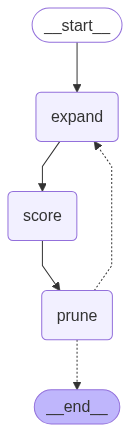

In [7]:
from IPython.display import Image, display

# Visualize the Tree of Thought workflow graph
display(Image(tot_graph.get_graph().draw_mermaid_png()))

In [ ]:
def play_wordle_with_tot(target_word: str = None, max_attempts: int = 6, 
                        tot_params: dict = None, interactive: bool = False) -> dict:
    """Play a complete game of Wordle using Tree of Thought for word selection
    
    Args:
        target_word: The target word (None for interactive mode)
        max_attempts: Maximum number of attempts
        tot_params: Tree of Thought parameters
        interactive: If True, ask user for feedback instead of simulating
    
    Returns:
        dict: Game result with statistics including generation and scoring counts
    """
    
    if tot_params is None:
        tot_params = {
            "max_depth": 2,          # How deep to search for word candidates
            "threshold": 0.80,       # Stop if we find a word with 95+ score (solution threshold)
            "high_threshold": 0.60,  # Threshold for normal pruning (keep good candidates)
            "retry_threshold": 0.40, # Minimum threshold for retry generation
            "k": 4,                  # Generate 4 word candidates per round
            "beam_size": 3           # Keep top 3 candidates for next iteration
        }
    
    # Handle interactive mode setup
    if interactive:
        if target_word is None:
            target_word = "UNKNOWN"  # Placeholder for interactive mode
        print(f"🎮 Starting INTERACTIVE Wordle session!")
        print(f"💡 I'll suggest words using Tree of Thought, you provide the feedback!")
        print(f"🎯 Word length: {WORD_MANAGER.word_length} letters")
    else:
        if target_word is None:
            target_word = get_target_word(0)  # Get random target word
        print(f"🎯 Starting Wordle game with target word: '{target_word.upper()}'")
    
    # Initialize game state and performance counters
    game_state = WordleGameState(target_word=target_word)
    total_generations = 0
    total_scorings = 0
    
    print("=" * 50)
    
    attempt = 1
    while not game_state.solved and attempt <= max_attempts:
        print(f"\n📝 Attempt {attempt}/{max_attempts}")
        print(f"Previous guesses: {', '.join(game_state.guesses)}")
        
        # Use Tree of Thought to find the best next word
        print("\n🧠 Using Tree of Thought to find next word...")
        
        tot_result = tot_graph.stream(
            {
                "game_state": game_state,
                "candidates": [],
                "scored_candidates": [],
                "depth": 0,
                "generation_count": 0,  # Initialize generation counter
                "scoring_count": 0,     # Initialize scoring counter
                **tot_params
            },
            config={"configurable": {"thread_id": f"wordle_game_{attempt}"}},
        )
        
        # Extract the final best word from ToT and accumulate performance counts
        final_state = None
        attempt_generations = 0
        attempt_scorings = 0
        
        for step in tot_result:
            # Track generation and scoring counts from each step
            for node, state in step.items():
                if isinstance(state, dict):
                    if 'generation_count' in state:
                        attempt_generations += state['generation_count']
                    if 'scoring_count' in state:
                        attempt_scorings += state['scoring_count']
            
            # Keep the final prune state for word selection
            if step.get('prune'):
                final_state = step['prune']
        
        # Accumulate totals
        total_generations += attempt_generations
        total_scorings += attempt_scorings
        print(f"📊 Attempt {attempt} ToT stats: {attempt_generations} generations, {attempt_scorings} scorings")
        
        if not final_state or not final_state.get('candidates'):
            print("❌ ToT failed to generate candidates")
            if interactive:
                print("🔄 Will retry generation in next iteration...")
                continue  # Skip this iteration and try again
            else:
                # Fallback to a common starting word for simulated mode
                fallback_words = WORD_MANAGER.get_common_starting_words(1)
                next_word = fallback_words[0] if fallback_words else "crane"
                print(f"🎯 Using fallback word: '{next_word.upper()}'")
        else:
            best_candidate = final_state['candidates'][0]
            next_word = best_candidate.word
            print(f"🎯 ToT selected: '{next_word.upper()}' (score: {best_candidate.score:.2f})")
            if hasattr(best_candidate, 'llm_reasoning'):
                print(f"💭 Reasoning: {best_candidate.llm_reasoning[:100]}...")
        
        # Get feedback (interactive vs simulated)
        if interactive:
            # Interactive mode: ask user for real Wordle feedback
            try:
                feedback = get_user_feedback(next_word, WORD_MANAGER.word_length)
                
                # Manually add to game state (bypassing automatic simulation)
                game_state.guesses.append(next_word)
                game_state.feedback.append(feedback)
                game_state.attempts += 1
                
                # Check if solved (all green)
                if all(color == "green" for color in feedback.colors):
                    game_state.solved = True
                    print(f"\n🎉 SUCCESS! Solved in {attempt} attempts!")
                    break
                    
            except InvalidWordException as e:
                print(f"⚠️ Word not accepted: {e.message}")
                
                # Try to get an alternative word from remaining candidates
                if final_state and len(final_state.get('candidates', [])) > 1:
                    # Use the next best candidate
                    alt_candidate = final_state['candidates'][1]
                    print(f"🎯 Trying alternative: '{alt_candidate.word.upper()}' (score: {alt_candidate.score:.2f})")
                    next_word = alt_candidate.word
                    
                    # Remove the failed word from candidates and try again
                    final_state['candidates'] = final_state['candidates'][1:]
                    continue  # Retry with alternative word (don't increment attempt)
                else:
                    print("❌ No alternative words available. Generating new candidates...")
                    # Continue to next iteration to regenerate words
                    continue
                
        else:
            # Simulated mode: automatic feedback generation
            feedback = game_state.add_guess(next_word)
            print(f"📊 Feedback: {feedback}")
            
            if game_state.solved:
                print(f"\n🎉 SUCCESS! Solved in {attempt} attempts!")
                break
        
        attempt += 1
    
    if not game_state.solved:
        if interactive:
            print(f"\n⏰ Reached maximum attempts ({max_attempts})")
            print(f"💡 Feel free to continue manually or start a new session!")
        else:
            print(f"\n😞 Failed to solve. The word was: '{target_word.upper()}'")
    
    print(f"\n📈 Final game statistics:")
    if interactive:
        print(f"  Mode: Interactive ({WORD_MANAGER.word_length}-letter)")
        print(f"  Target: [Hidden - you know it! 😉]")
    else:
        print(f"  Target: {target_word.upper()}")
    print(f"  Attempts: {game_state.attempts}/{max_attempts}")
    print(f"  Success: {'Yes' if game_state.solved else 'No'}")
    print(f"  Guesses: {' → '.join(guess.upper() for guess in game_state.guesses)}")
    print(f"  ToT Performance:")
    print(f"    Total generations: {total_generations}")
    print(f"    Total scorings: {total_scorings}")
    if game_state.attempts > 0:
        print(f"    Avg generations per attempt: {total_generations/game_state.attempts:.1f}")
        print(f"    Avg scorings per attempt: {total_scorings/game_state.attempts:.1f}")
    
    # Return comprehensive result
    return {
        'game_state': game_state,
        'target_word': target_word if not interactive else "HIDDEN",
        'solved': game_state.solved,
        'attempts': game_state.attempts,
        'max_attempts': max_attempts,
        'guesses': game_state.guesses,
        'interactive_mode': interactive,
        'word_length': WORD_MANAGER.word_length,
        'success_rate': 1.0 if game_state.solved else 0.0,
        'efficiency_score': (max_attempts - game_state.attempts + 1) / max_attempts if game_state.solved else 0.0,
        'tot_performance': {
            'total_generations': total_generations,
            'total_scorings': total_scorings,
            'avg_generations_per_attempt': total_generations / game_state.attempts if game_state.attempts > 0 else 0,
            'avg_scorings_per_attempt': total_scorings / game_state.attempts if game_state.attempts > 0 else 0,
            'total_llm_calls': total_generations + total_scorings
        }
    }

# Test the system with a sample word
test_word = get_target_word(0)  # Get first target word

# LLM setup
llm = ChatOpenAI(model="gpt-4.1-nano")
scoring_llm = ChatOpenAI(model="gpt-4.1-nano")

# Bound LLMs for each task
word_generator = generation_prompt | llm.with_structured_output(GuessWords)
word_scorer = scoring_prompt | llm.with_structured_output(WordleScoring)

In [9]:
# 📊 DEMO: Enhanced Performance Tracking with Generation & Scoring Counters
print("🎯 Testing Enhanced Performance Tracking")
print("=" * 50)

# Test with current word length
current_word = get_target_word(0)
print(f"Playing with {WORD_MANAGER.word_length}-letter word: '{current_word.upper()}'")



def analyze_tot_performance(result: dict):
    """Detailed analysis of ToT performance metrics"""
    print(f"\n🔍 Detailed ToT Performance Analysis")
    print("=" * 40)
    
    perf = result['tot_performance']
    game_state = result['game_state']
    
    print(f"🎯 Game Outcome:")
    print(f"  Target: {result['target_word'].upper()}")
    print(f"  Result: {'✅ SOLVED' if result['solved'] else '❌ FAILED'}")
    print(f"  Attempts: {result['attempts']}/{result['max_attempts']}")
    print(f"  Efficiency: {result['efficiency_score']:.1%}")
    
    print(f"\n📊 ToT Algorithm Performance:")
    print(f"  Total LLM Calls: {perf['total_llm_calls']}")
    print(f"    • Word Generation Calls: {perf['total_generations']}")
    print(f"    • Word Scoring Calls: {perf['total_scorings']}")
    print(f"  Per-Attempt Averages:")
    print(f"    • {perf['avg_generations_per_attempt']:.1f} generations per attempt")
    print(f"    • {perf['avg_scorings_per_attempt']:.1f} scorings per attempt")
    print(f"    • {perf['total_llm_calls']/result['attempts']:.1f} total LLM calls per attempt")
    
    # Calculate some efficiency metrics
    if perf['total_generations'] > 0:
        scoring_ratio = perf['total_scorings'] / perf['total_generations']
        print(f"  Scoring-to-Generation Ratio: {scoring_ratio:.1f}")
        
    if result['solved']:
        llm_efficiency = result['attempts'] / perf['total_llm_calls']
        print(f"  LLM Efficiency: {llm_efficiency:.3f} attempts per LLM call")
    
    return result

# # Analyze our demo result
# # Run a quick test game
# demo_result = play_wordle_with_tot(
#     target_word=current_word,
#     tot_params={
#         "max_depth": 1,          # Shallow depth for quick demo
#         "threshold": 0.75,       
#         "high_threshold": 0.50,  # Lower thresholds for more interesting behavior
#         "retry_threshold": 0.30, 
#         "k": 2,                  # Generate 2 candidates per round  
#         "beam_size": 1           # Keep top 1 candidate
#     }
# )
# analyzed_result = analyze_tot_performance(demo_result)

# Show how to access the counters programmatically
# print(f"\n💻 Programmatic Access:")
# print(f"  result['tot_performance']['total_generations'] = {demo_result['tot_performance']['total_generations']}")
# print(f"  result['tot_performance']['total_scorings'] = {demo_result['tot_performance']['total_scorings']}")
# print(f"  result['tot_performance']['total_llm_calls'] = {demo_result['tot_performance']['total_llm_calls']}")

# print(f"\n✨ Performance tracking is now fully integrated!")
# print(f"   Every call to play_wordle_with_tot() returns detailed ToT performance metrics.")


🎯 Testing Enhanced Performance Tracking
Playing with 5-letter word: 'AHURA'


In [10]:
# 🎮 INTERACTIVE MODE DEMO - Play Real Wordle with ToT Assistance!

def start_interactive_wordle(word_length: int = 5, max_attempts: int = 6):
    """Start an interactive Wordle session with Tree of Thought assistance"""
    
    print("🎮 Welcome to Interactive Tree of Thought Wordle!")
    print("=" * 50)
    print("HOW IT WORKS:")
    print("1. 🧠 I'll use Tree of Thought to suggest the best word")
    print("2. 📝 You enter that word in your actual Wordle game")
    print("3. 🎯 You tell me the color feedback you received")
    print("4. 🔄 We repeat until solved or max attempts reached")
    print()
    print("FEEDBACK FORMAT:")
    print("  • G or 🟩 = Green (correct letter, correct position)")
    print("  • Y or 🟨 = Yellow (correct letter, wrong position)")
    print("  • B or ⬜ = Black/Gray (letter not in word)")
    print("  • Examples: 'GYBGG', '🟩🟨⬜🟩🟩', 'green yellow black green green'")
    print()
    
    # Set word length
    set_word_length(word_length)
    
    print(f"🎯 Ready to play {word_length}-letter Wordle!")
    print("📱 Go to your Wordle game and let's start!")
    
    # Ask user if they're ready
    ready = input("\nAre you ready to start? (y/n): ").strip().lower()
    if ready not in ['y', 'yes']:
        print("👋 Come back when you're ready!")
        return None
    
    # Start the interactive session
    return play_wordle_with_tot(
        target_word=None,  # No target word in interactive mode
        max_attempts=max_attempts,
        interactive=True,
        tot_params={
            "max_depth": 5,
            "threshold": 0.90,
            "high_threshold": 0.60,
            "retry_threshold": 0.40,
            "k": 3,
            "beam_size": 2
        }
    )

In [16]:
import os
   # model="deepseek/deepseek-r1",
    # model="qwen/qwen3-235b-a22b",
    # model="anthropic/claude-sonnet-4",
    # model="moonshotai/kimi-vl-a3b-thinking",
    # model="mistralai/magistral-medium-2506:thinking",
    # model="openai/o4-mini",
    
MODEL = "qwen/qwen3-235b-a22b"
llm = ChatOpenAI(
    model=MODEL,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    
)
scoring_llm = ChatOpenAI(
    model=MODEL,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
)

# Bound LLMs for each task
word_generator = generation_prompt | llm.with_structured_output(GuessWords)
word_scorer = scoring_prompt | llm.with_structured_output(WordleScoring)


start_interactive_wordle(5)

🎮 Welcome to Interactive Tree of Thought Wordle!
HOW IT WORKS:
1. 🧠 I'll use Tree of Thought to suggest the best word
2. 📝 You enter that word in your actual Wordle game
3. 🎯 You tell me the color feedback you received
4. 🔄 We repeat until solved or max attempts reached

FEEDBACK FORMAT:
  • G or 🟩 = Green (correct letter, correct position)
  • Y or 🟨 = Yellow (correct letter, wrong position)
  • B or ⬜ = Black/Gray (letter not in word)
  • Examples: 'GYBGG', '🟩🟨⬜🟩🟩', 'green yellow black green green'

📚 Loaded 9979 valid 5-letter words
🎯 Switched to 5-letter Wordle mode!
   Available words: 9979
   Suggested starters: []
🎯 Ready to play 5-letter Wordle!
📱 Go to your Wordle game and let's start!
🎮 Starting INTERACTIVE Wordle session!
💡 I'll suggest words using Tree of Thought, you provide the feedback!
🎯 Word length: 5 letters

📝 Attempt 1/6
Previous guesses: 

🧠 Using Tree of Thought to find next word...
Expanding with seed: None
GAME HISTORY:  No previous guesses.
Generating 3 word ca

KeyboardInterrupt: 